In [1]:
import scvi
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import *

/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom inst

In [2]:
import scipy
rna = scipy.io.mmread('DSS-prim-merge10-RNA.raw_UMI.merged.converted_barcodes.mtx')

In [3]:
rna

<55291x111877 sparse matrix of type '<class 'numpy.int64'>'
	with 68118175 stored elements in COOrdinate format>

In [6]:
meta = pd.read_csv('DSS-prim-merge10-RNA.qc_stats.singlet.txt', sep='\t')
meta

,X,R1,R2,R3,P5,unique,mm10_total,mm10_dup,libsize,barcode,log10UMI,det_genes,sample,replicate,batch
1,258,R1.001,R2.002,R3.066,P1.02,1816,3729,0.513006,2240,"R1.001,R2.002,R3.066,P1.02",3.259116,1816,Colitis_acute,DSS17-DSS-m1,DSS17
2,1939,R1.001,R2.011,R3.019,P1.02,691,1372,0.496356,872,"R1.001,R2.011,R3.019,P1.02",2.839478,691,Colitis_acute,DSS17-DSS-m1,DSS17
3,4628,R1.001,R2.025,R3.020,P1.02,1404,3019,0.534945,1685,"R1.001,R2.025,R3.020,P1.02",3.147367,1404,Colitis_acute,DSS17-DSS-m1,DSS17
4,6213,R1.001,R2.033,R3.069,P1.02,3188,5501,0.420469,4539,"R1.001,R2.033,R3.069,P1.02",3.503518,3188,Colitis_acute,DSS17-DSS-m1,DSS17
5,6997,R1.001,R2.037,R3.085,P1.02,765,1647,0.535519,917,"R1.001,R2.037,R3.085,P1.02",2.883661,765,Colitis_acute,DSS17-DSS-m1,DSS17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111873,3520173,R1.096,R2.095,R3.045,P1.69,532,784,0.321429,941,"R1.096,R2.095,R3.045,P1.69",2.725912,532,Control,DSS15-Control-m5,DSS15
111874,3520327,R1.096,R2.096,R3.007,P1.69,3427,4988,0.312951,6201,"R1.096,R2.096,R3.007,P1.69",3.534914,3427,Control,DSS15-Control-m5,DSS15
111875,3520351,R1.096,R2.096,R3.031,P1.69,612,806,0.240695,1393,"R1.096,R2.096,R3.031,P1.69",2.786751,612,Control,DSS15-Control-m5,DSS15
111876,3520365,R1.096,R2.096,R3.045,P1.69,4500,6884,0.346310,7480,"R1.096,R2.096,R3.045,P1.69",3.653213,4500,Control,DSS15-Control-m5,DSS15


In [ ]:
adata = ad.AnnData(X=csr_matrix(rna.T))
# adata.obs.index=rna.columns
# adata.var.index=rna.index
adata.obs = meta.copy()
# adata.obs.index = rna.columns

gene_name = np.loadtxt('DSS-long-merge4-RNA.gene_names.list', dtype='str')
adata.var.index = gene_name
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# mitochondrial genes
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", 'ribo'], inplace=True, percent_top=[20], log1p=True)

import scanpy as sc
adata = adata.copy()
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=10000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
    span=0.5
)



In [16]:
adata

AnnData object with n_obs × n_vars = 111877 × 10000
    obs: 'X', 'R1', 'R2', 'R3', 'P5', 'unique', 'mm10_total', 'mm10_dup', 'libsize', 'barcode', 'log10UMI', 'det_genes', 'sample', 'replicate', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [17]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["batch"],
)

model = scvi.model.SCVI(adata, n_latent=20, gene_likelihood="nb")
model.to_device('cuda')
model.train(max_epochs=300, train_size=0.9, validation_size=0.1)

SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be 

Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [18]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

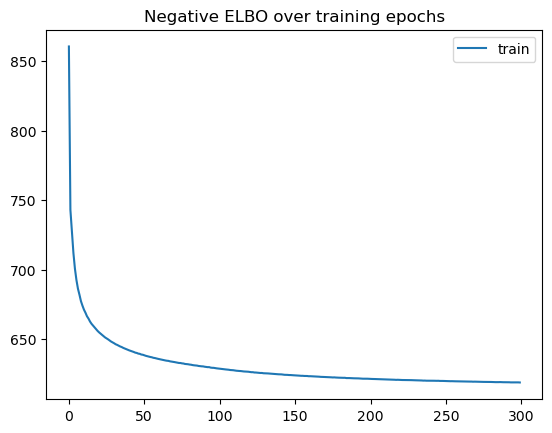

In [19]:
import matplotlib.pyplot as plt
plt.plot(model.history["elbo_train"], label="train")
# plt.plot(model.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
# plt.ylim(1100, 1500)
plt.legend()

In [ ]:

adata.obsm['X_pca'] = adata.obsm['X_scVI']
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'sample'], ncols=1)

In [23]:
scVI_df = pd.DataFrame(adata.obsm['X_scVI'], index=adata.obs.index)
scVI_df.to_csv('scVI_PCs_all.txt.gz', sep='\t', index=True)

In [24]:
scVI_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,2.294299,0.315159,-0.470071,1.425605,1.156471,0.339893,-1.101378,1.675276,0.366324,-0.560468,-1.707602,0.012785,-1.068174,-0.558480,0.176206,0.657515,1.058171,-1.623838,0.427532,1.020074
2,-0.360116,-0.968333,0.728756,0.047749,0.453244,1.764114,-0.110936,0.799015,-0.167810,-0.233740,-1.343617,-0.321849,-1.837133,0.735125,0.769344,-0.564336,0.759131,0.057915,-1.173130,-0.222760
3,1.766389,-0.900861,-1.599113,0.416298,0.340145,1.765002,0.381070,1.457785,0.990322,0.220896,-1.205842,0.179533,-0.524338,-0.774882,-1.475707,0.810168,0.335494,-0.828448,-0.846925,0.692364
4,2.038089,1.297752,1.227514,0.701935,1.024641,1.395839,-0.510723,1.911869,0.367311,0.294259,1.637534,-0.576602,-1.898224,-1.432821,0.650058,-0.100796,-0.340678,-0.271589,-0.688743,-0.130359
5,-0.357981,-1.409024,-0.059043,1.867274,2.662503,-0.044528,-0.790252,1.210217,1.978884,-1.566670,-0.786731,2.717988,-0.543058,-0.127915,-0.436087,1.764633,-0.233231,-1.838239,-0.138989,0.373653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111873,-0.179261,-0.182885,0.378859,-0.855100,-0.159840,-1.068730,0.405216,0.100834,0.305660,0.299476,0.175385,-0.354096,0.869898,0.609650,0.505159,-0.411057,0.315762,-0.176166,-0.471721,0.455171
111874,-0.667392,-0.256959,0.740851,-0.797187,-1.235101,-1.315958,0.186506,0.826496,0.266124,-0.932302,-0.396131,-1.280148,0.270749,-1.755961,0.370027,-0.495838,-0.275761,-0.905489,-0.904716,0.718830
111875,1.153188,-1.162162,0.320735,0.261977,-0.843868,0.670768,1.297191,1.330699,0.244747,-1.795479,-0.633951,0.712859,-1.116680,-0.516271,1.195351,-0.977329,-0.658797,0.246623,0.622463,0.101943
111876,-0.679652,1.369918,2.458348,2.732350,-0.427713,-1.929691,2.025448,-0.724976,-0.666669,0.411484,-0.071872,0.919292,0.899315,-5.247037,-0.458444,-0.079158,0.518287,-0.245397,-1.278589,0.526078
